# Optimizing Cross-Entropy

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize

## Regularized Cross-Entropy

Consider $N$ points $(\mathbf{x}_0,y_0),\dots,(\mathbf{x}_{N-1},y_{N-1})$ where $\mathbf{x}_k \in \mathbb{R}^n$ for each $k$, and $y_k = 0$ or $y_k = 1$ for each $k$. The goal of logistic regression is to compute parameters $\mathbf{W} \in \mathbb{R}^n$ and $b \in \mathbb{R}$ which minimize the regularized cross entropy function

$$
C(\mathbf{W},b,\alpha) = -\frac{1}{N} \sum_{k=0}^{N-1} \left( y_k \log(\sigma(\mathbf{x}_k; \mathbf{W},b)) + (1 - y_k) \log(1 - \sigma(\mathbf{x}_k; \mathbf{W},b)) \right) + \alpha \Vert \mathbf{W} \Vert^2
$$

where $\alpha > 0$ is the regularization parameter and

$$
\sigma(\mathbf{x}; \mathbf{W},b) = \frac{1}{1 + e^{- \left( \langle \mathbf{W} , \mathbf{x} \rangle + b \right)}}
$$

## Gradient of Cross-Entropy

We need to compute the gradient of $C(\mathbf{W},b,\alpha)$ to implement the gradient descent method to find optimal parameters for logistic regression. Let's begin with the derivatives of the logistic function $\sigma(\mathbf{x}; \mathbf{W},b)$ where $\mathbf{x} = (x_0,\dots,x_{n-1})$ and $\mathbf{W} = (W_0,\dots,W_{n-1})$.

Let $z = \langle \mathbf{W} , \mathbf{x} \rangle + b$ and $\sigma(z) = \sigma(\mathbf{x}; W,b)$. Recall

$$
\sigma'(z) = \sigma(z) (1 - \sigma(z))
$$

Compute and simplify the partial derivative with respect to $W_{\ell}$

$$
\frac{\partial \sigma}{\partial W_{\ell}} = \sigma'(z) \frac{\partial z}{\partial W_{\ell}} = \sigma(z) (1 - \sigma(z)) x_{\ell}
$$

where $x_{\ell}$ is the entry of $\mathbf{x}$ at index $\ell$. Therefore

$$
\frac{\partial \sigma}{\partial W_{\ell}} = x_{\ell} \sigma(\mathbf{x}; \mathbf{W},b) (1 - \sigma(\mathbf{x}; \mathbf{W},b))
$$

Similarly

$$
\frac{\partial \sigma}{\partial b} = \sigma'(z) \frac{\partial z}{\partial b} = \sigma(\mathbf{x}; \mathbf{W},b) (1 - \sigma(\mathbf{x}; \mathbf{W},b))
$$

Compute the partial derivative of $C(\mathbf{W},b,\alpha)$ with respect to $W_{\ell}$

$$
\begin{align*}
\frac{\partial C}{\partial W_{\ell}} &= -\frac{1}{N} \sum_{k=0}^{N-1} \left( y_k x_{k,\ell} (1 - \sigma(\mathbf{x}_k; \mathbf{W},b)) - (1 - y_k) x_{k,\ell} \sigma(\mathbf{x}_k; \mathbf{W},b) \right) + 2 \alpha W_{\ell} \\
&= -\frac{1}{N} \sum_{k=0}^{N-1} x_{k,\ell} \left( y_k - \sigma(\mathbf{x}_k; \mathbf{W},b) \right) + 2 \alpha W_{\ell}
\end{align*}
$$

where $x_{k,\ell}$ is the entry of $\mathbf{x}_k$ at index $\ell$. Similarly

$$
\frac{\partial C}{\partial b} = -\frac{1}{N} \sum_{k=0}^{N-1} \left( y_k - \sigma(\mathbf{x}_k; \mathbf{W},b) \right)
$$

Note that we can write these derivatives in matrix notation as

$$
\left( \frac{\partial C}{\partial W_0} , \dots, \frac{\partial C}{\partial W_{N-1}} \right) = -\frac{1}{N} X^T (\mathbf{y} - \sigma(X; \mathbf{W},b)) + 2 \alpha \mathbf{W}
$$

where

$$
X = \begin{bmatrix} & \mathbf{x}_0 & \\ & \mathbf{x}_1 & \\ & \vdots & \\ & \mathbf{x}_{N-1} & \end{bmatrix}
\hspace{20mm}
\mathbf{y} = \begin{bmatrix} y_0 \\ y_1 \\ \vdots \\ y_{N-1} \end{bmatrix}
\hspace{20mm}
\sigma(X; \mathbf{W},b) = \begin{bmatrix} \sigma(\mathbf{x}_0; \mathbf{W},b) \\ \sigma(\mathbf{x}_1; \mathbf{W},b) \\ \vdots \\ \sigma(\mathbf{x}_{N-1}; \mathbf{W},b) \end{bmatrix}
$$

## Implementation

In [3]:
def gradient_descent(f,grad,x0,alpha=0.1,max_iter=100,eps=1e-4):
    X = np.zeros([max_iter+1,len(x0)])
    X[0,:] = x0
    for k in range(max_iter):
        xk = X[k,:]
        grad_xk = grad(xk)
        if np.linalg.norm(grad_xk) < eps:
            # Truncate the matrix X to include
            # only rows up to current index k
            X = X[:k+1,:]
            break
        X[k+1,:] = xk - alpha*grad_xk
    return X

In [4]:
def C(W,b,X,y,alpha):
    N,p = X.shape
    W = np.array(W).reshape(p,1)
    y = np.array(y).reshape(N,1)
    S = 1/(1 + np.exp(-(X@W + b)))
    E = -1/N*np.sum(y*np.log(S) + (1 - y)*np.log(1 - S))
    R = alpha*np.sum(W*W)
    return E + R

def gradC(W,b,X,y,alpha):
    N,p = X.shape
    W = np.array(W).reshape(p,1)
    y = np.array(y).reshape(N,1)
    S = 1/(1 + np.exp(-(X@W + b)))
    dCdW = -1/N*X.T@(y - S) + 2*alpha*W
    dCdb = -1/N*np.sum(y - S)
    return np.hstack([dCdW.flatten(),dCdb])

Let's apply gradient descent to the regularized cross-entropy function for the example below:

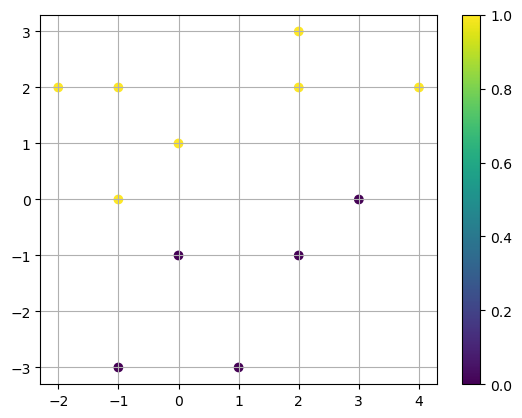

In [5]:
X = np.array([[2,3],[-1,2],[0,1],[1,-3],[4,2],[-1,-3],[3,0],[2,2],[2,-1],[-2,2],[-1,0],[0,-1]])
y = [1,1,1,0,1,0,0,1,0,1,1,0]
plt.scatter(X[:,0],X[:,1],c=y), plt.colorbar()
plt.grid(True)
plt.show()

Define the vector function $f(\mathbf{x})$ and $\nabla f$ which represents $C(\mathbf{W},b,\alpha)$ and its gradient.

In [6]:
alpha = 0.01
f = lambda x: C(x[:-1],x[-1],X,y,alpha)
gradf = lambda x: gradC(x[:-1],x[-1],X,y,alpha)

Apply gradient descent:

In [7]:
P = gradient_descent(f,gradf,[-1,3,1],alpha=0.01,max_iter=1000,eps=1e-10)

View the first 5 points:

In [8]:
P[:5]

array([[-1.        ,  3.        ,  1.        ],
       [-1.00005735,  2.9996237 ,  0.99994556],
       [-1.00011447,  2.99924761,  0.99989116],
       [-1.00017135,  2.99887172,  0.9998368 ],
       [-1.000228  ,  2.99849603,  0.99978248]])

And the last 5 points in the:

In [9]:
P[-5:]

array([[-0.98715577,  2.71251609,  0.95642125],
       [-0.98710747,  2.7123004 ,  0.95638196],
       [-0.98705914,  2.71208484,  0.95634266],
       [-0.98701079,  2.71186939,  0.95630337],
       [-0.98696242,  2.71165406,  0.95626408]])

Let's compare to the result computed by `LogisticRegression`.

In [10]:
model = LogisticRegression(C=10).fit(X,y)

In [11]:
model.coef_

array([[-1.09701124,  3.02449763]])

In [12]:
model.intercept_

array([0.93960308])

The result is similar but not exactly the same. We can take a closer look at the documentation for `LogisticRegression` to see how it works.

Let's also compare the result computed by `scipy.optimize.minimize`.

In [14]:
result = minimize(f,[-1,3,1])

In [15]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.12531909819295892
        x: [-8.221e-01  2.314e+00  7.267e-01]
      nit: 13
      jac: [-3.505e-06  2.082e-06 -7.134e-06]
 hess_inv: [[ 5.836e+00 -4.121e+00 -6.103e+00]
            [-4.121e+00  1.443e+01  2.905e+00]
            [-6.103e+00  2.905e+00  2.368e+01]]
     nfev: 60
     njev: 15

In [16]:
result.x

array([-0.82214028,  2.31409619,  0.72666696])

Again the result is similar but not exactly the same.